# *QOSF Mentorship Program*

**Candidate: Wasiq Malik**

# The Max-Cut Problem
This is the first problem that was solved using [QAOA](https://arxiv.org/abs/1411.4028) was MaxCut. 

The problem is defined as follows: 
Suppose we have a graph $\mathcal{G}= \{\mathcal{V},\mathcal{E}\}$ where $\mathcal{E}$ are the edges and $\mathcal{V}$ the vertices. Given a partition of these vertices into a subset $\mathcal{P}_0$ and its complement $\mathcal{P}_1 = \mathcal{V}\setminus \mathcal{P}_0$, the corresponding cut set $C\subseteq \mathcal{E}$ is the subset of edges that have one endpoint in $\mathcal{P}_0$ and the other endpoint in $\mathcal{P}_1$. The maximum cut (MaxCut) for a given graph $\mathcal{G}$ is the choice of $\mathcal{P}_0$ and $\mathcal{P}_1$ which yields the largest possible cut set. 

The difficulty of finding this partition is well known to be an NP-Complete problem in general.

**Setting things up**

In [8]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
import random
from scipy.optimize import minimize
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    import cirq
    print("installed cirq.")


In [2]:
# Utility function to print a graph
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Classical Brute-Force Solution
The Brute-Force Algorithm would check all possible cuts of the weighted graph and pick the cut which has the maximum value.

A cut can be represented by a bit string of length $\mathcal{N}$, where $\mathcal{N}$ is the total verticies in the graph. A bit being 0 represents that node being in partition $\mathcal{P}_0$ whereas, a bit having the value 1 represents the $\mathcal{P}_1$ partition.

This encoding of the problem presents $\mathcal{2}^n$ possible bit strings, we can calculate the cut value for each possibility and find out which configuration had the maximum cut value. This will be our optimal solution.

The running time of this Algorithm is $\mathcal{O(2}^n)$.

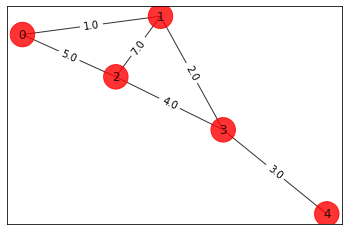

In [3]:
n=5 # Number of nodes in graph

# create a graph of n nodes
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))  

# edge are in the form (vertex u, vertex v, edge weight)
edges=[(0,1,1.0),(0,2,5.0),(1,2,7.0),(1,3,2.0),(2,3,4.0), (3,4,3.0)]

G.add_weighted_edges_from(edges)    # create weighted edges in the graph

# setup an example graph
colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix for the example graph
weight_matrix = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        edge = G.get_edge_data(i,j,default=0)
        if edge != 0:
            weight_matrix[i,j] = edge['weight'] 

bit string = [0, 0, 0, 0, 0] cut value = 0.0
bit string = [1, 0, 0, 0, 0] cut value = 6.0
bit string = [0, 1, 0, 0, 0] cut value = 10.0
bit string = [1, 1, 0, 0, 0] cut value = 14.0
bit string = [0, 0, 1, 0, 0] cut value = 16.0
bit string = [1, 0, 1, 0, 0] cut value = 12.0
bit string = [0, 1, 1, 0, 0] cut value = 12.0
bit string = [1, 1, 1, 0, 0] cut value = 6.0
bit string = [0, 0, 0, 1, 0] cut value = 9.0
bit string = [1, 0, 0, 1, 0] cut value = 15.0
bit string = [0, 1, 0, 1, 0] cut value = 15.0
bit string = [1, 1, 0, 1, 0] cut value = 19.0
bit string = [0, 0, 1, 1, 0] cut value = 17.0
bit string = [1, 0, 1, 1, 0] cut value = 13.0
bit string = [0, 1, 1, 1, 0] cut value = 9.0
bit string = [1, 1, 1, 1, 0] cut value = 3.0
bit string = [0, 0, 0, 0, 1] cut value = 3.0
bit string = [1, 0, 0, 0, 1] cut value = 9.0
bit string = [0, 1, 0, 0, 1] cut value = 13.0
bit string = [1, 1, 0, 0, 1] cut value = 17.0
bit string = [0, 0, 1, 0, 1] cut value = 19.0
bit string = [1, 0, 1, 0, 1] cut value = 1

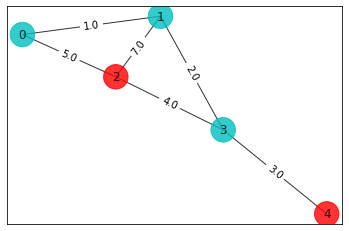

In [5]:
# running the brute force algorithm to find the max cut for the example graph
best_cost_brute = best_sol_brute = 0
for bit_string in range(2**n):
    solution = [int(t) for t in reversed(list(bin(bit_string)[2:].zfill(n)))] # generate bit strings representing the possible cuts
    cost = 0
    # calculate the cut value for current cut set
    for i in range(n):
        for j in range(n):
            cost = cost + weight_matrix[i,j]*solution[i]*(1-solution[j])
    # if better solution found, save it
    if best_cost_brute < cost:
        best_cost_brute = cost
        best_sol_brute = solution 
    print('bit string = ' + str(solution) + ' cut value = ' + str(cost))

# display the max cut solution
colors = ['r' if best_sol_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(best_sol_brute) + ' cost = ' + str(best_cost_brute))  

# Quantum Solution using QAOA

**Creating Sample Graph**

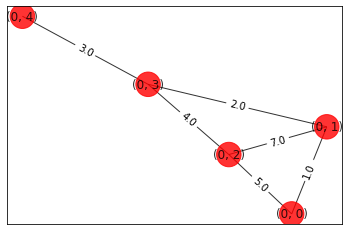

In [9]:
n=5 # Number of nodes in graph

qubits = [cirq.GridQubit(0, i) for i in range(0, n)]

G=nx.Graph()
G.add_nodes_from(qubits)
edges=[(qubits[0],qubits[1],1.0),(qubits[0],qubits[2],5.0),(qubits[1],qubits[2],7.0),(qubits[1],qubits[3],2.0),(qubits[2],qubits[3],4.0), (qubits[3],qubits[4],3.0)]

G.add_weighted_edges_from(edges)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)

**Create a General QAOA Circuit of depth $\mathcal{m}$**


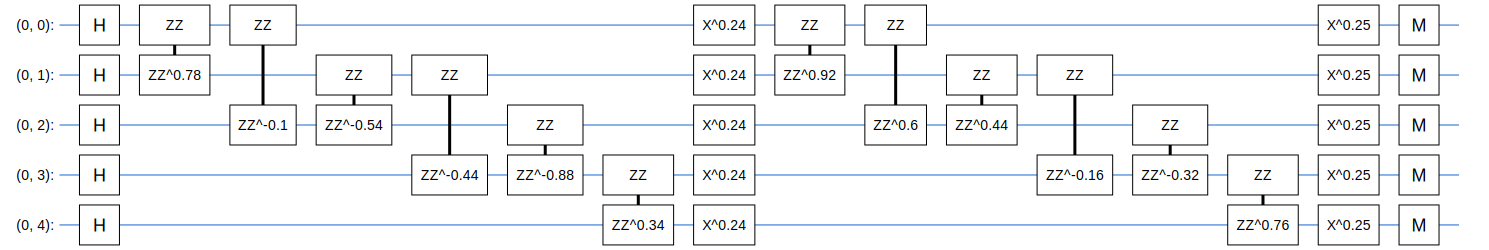

In [41]:
from cirq.contrib.svg import SVGCircuit
import sympy

# Depth for the QAOA 
m=2 
# Number of qubits
n=5
# repitions count for running the circuit
rep=10_000

def create_circuit(params):
    m = len(params)//2
    alphas = params[0:m]
    betas = params[m::]

    # Prepare equal superposition of qubits
    qaoa_circuit = cirq.Circuit(cirq.H.on_each(G.nodes()))

    # iterate over depth factor for qaoa
    for i in range(m):
        # insert the cost unitary
        for u, v, w in G.edges(data=True):
            qaoa_circuit.append(cirq.ZZ(u, v) ** (alphas[i] * w['weight']))
        # insert the mixer unitary
        qaoa_circuit.append(cirq.Moment(cirq.X(qubit) ** betas[i] for qubit in G.nodes()))

    # apply measurements at the end of the circuit
    for qubit in G.nodes():
        qaoa_circuit.append(cirq.measure(qubit))

    return qaoa_circuit

# create a circuit with random parameters
qaoa_circuit = create_circuit(params=[float(random.randint(-314, 314))/float(100) for i in range(0, m*2)])
# display the qaoa circuit
SVGCircuit(qaoa_circuit)


**Basic QAOA Circuit of Depth 1**

For the purpose of this example to run QAOA on weighted graphs, the weighted cost hamiltonian unitary has been implemented.

For simplicity sake, running QAOA on depth 1 with only 2 parameters.


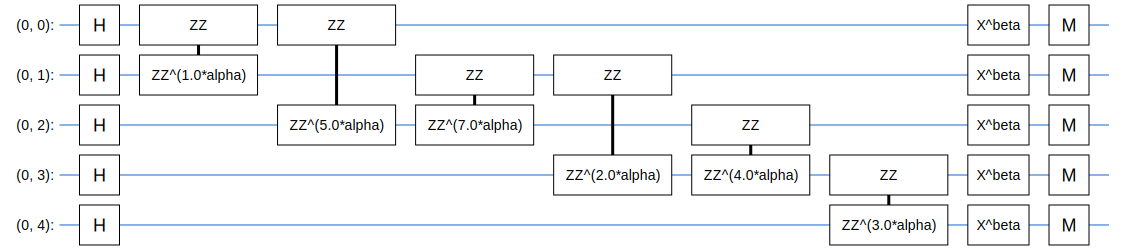

In [46]:
from cirq.contrib.svg import SVGCircuit
import sympy

# Symbols for the rotation angles in the QAOA circuit.
alpha = sympy.Symbol('alpha')
beta = sympy.Symbol('beta')

qaoa_circuit = cirq.Circuit(
    # Prepare equal superposition of qubits
    cirq.H.on_each(G.nodes()),

    # Do ZZ operations between neighbors u, v in the graph. Here, u is a qubit,
    # v is its neighboring qubit, and w is the weight between these qubits.
    (cirq.ZZ(u, v) ** (alpha * w['weight']) for (u, v, w) in G.edges(data=True)),

    # Apply X operations along all nodes of the graph. Again working_graph's
    # nodes are the working_qubits. Note here we use a moment
    # which will force all of the gates into the same line.
    cirq.Moment(cirq.X(qubit) ** beta for qubit in G.nodes()),

    # All relevant things can be computed in the computational basis.
    (cirq.measure(qubit) for qubit in G.nodes()),
)
SVGCircuit(qaoa_circuit)

**Calculate the expected cost value for a specific parameterized QAOA circuit**

In [47]:
def estimate_cost(graph, samples):
    """Estimate the cost function of the QAOA on the given graph using the
    provided computational basis bitstrings."""
    cost_value = 0.0

    # Loop over edge pairs and compute contribution.
    for u, v, w in graph.edges(data=True):
      u_samples = samples[str(u)]
      v_samples = samples[str(v)]

      # Determine if it was a +1 or -1 eigenvalue.
      u_signs = (-1)**u_samples
      v_signs = (-1)**v_samples
      term_signs = u_signs * v_signs

      # Add scaled term to total cost.
      term_val = np.mean(term_signs) * w['weight']
      cost_value += term_val

    return -cost_value

**Testing expectation values for the circuit**

In [48]:
alpha_value = np.pi / 4
beta_value = np.pi / 2
sim = cirq.Simulator()

sample_results = sim.sample(
    qaoa_circuit, 
    params={alpha: alpha_value, beta: beta_value}, 
    repetitions=20_000
)
print(f'Alpha = {round(alpha_value, 3)} Beta = {round(beta_value, 3)}')
print(f'Estimated cost: {estimate_cost(G, sample_results)}')

Alpha = 0.785 Beta = 1.571
Estimated cost: 0.32899999999999974


**Optimizing the search space for two paramters, alpha and beta**

In [ ]:
# Set the grid size = number of points in the interval [0, 2π).
grid_size = 5

exp_values = np.empty((grid_size, grid_size))
par_values = np.empty((grid_size, grid_size, 2))

for i, alpha_value in enumerate(np.linspace(0, 2 * np.pi, grid_size)):
  for j, beta_value in enumerate(np.linspace(0, 2 * np.pi, grid_size)):
    samples = sim.sample(
        qaoa_circuit,
        params={alpha: alpha_value, beta: beta_value},
        repetitions=20000
    )
    exp_values[i][j] = estimate_cost(G, samples)
    par_values[i][j] = alpha_value, beta_value

**Utility Function to display Graph partitions**

In [ ]:
def output_cut(S_partition):
  """Plot and output the graph cut information."""

  # Generate the colors.
  coloring = []
  for node in G:
    if node in S_partition:
      coloring.append('blue')
    else:
      coloring.append('red')

  # Get the weights
  edges = G.edges(data=True)
  weights = [w['weight'] for (u,v, w) in edges]

  nx.draw_circular(
      G,
      node_color=coloring,
      node_size=1000,
      with_labels=True,
      width=weights)
  plt.show()
  size = nx.cut_size(G, S_partition, weight='weight')
  print(f'Cut size: {size}')

**Setting learned optimal parameters**

In [ ]:
best_exp_index = np.unravel_index(np.argmax(exp_values), exp_values.shape)
best_parameters = par_values[best_exp_index]
print(f'Best control parameters: {best_parameters}')

Best control parameters: [3.14159265 1.57079633]


**Execute QAOA to find approximate solution to the max cut for Sample Graph**

In [ ]:
# Number of candidate cuts to sample.
num_cuts = 100
candidate_cuts = sim.sample(
    qaoa_circuit,
    params={alpha: best_parameters[0], beta: best_parameters[1]},
    repetitions=num_cuts
)

# Variables to store best cut partitions and cut size.
best_qaoa_S_partition = set()
best_qaoa_T_partition = set()
best_qaoa_cut_size = -np.inf

# Analyze each candidate cut.
for i in range(num_cuts):
  candidate = candidate_cuts.iloc[i]
  one_qubits = set(candidate[candidate==1].index)
  S_partition = set()
  T_partition = set()
  for node in G:
    if str(node) in one_qubits:
      # If a one was measured add node to S partition.
      S_partition.add(node)
    else:
      # Otherwise a zero was measured so add to T partition.
      T_partition.add(node)

  cut_size = nx.cut_size(
      G, S_partition, T_partition, weight='weight')

  # If you found a better cut update best_qaoa_cut variables.
  if cut_size > best_qaoa_cut_size:
    best_qaoa_cut_size = cut_size
    best_qaoa_S_partition = S_partition
    best_qaoa_T_partition = T_partition

**Randomnly Generate Solutions for the maxcut and pick the best one out of 100**

We can use this to compare the results with the QAOA.

In [ ]:

best_random_S_partition = set()
best_random_T_partition = set()
best_random_cut_size = -9999

# Randomly build candidate sets.
for i in range(num_cuts):
  S_partition = set()
  T_partition = set()
  for node in G:
    if random.random() > 0.5:
      # If we flip heads add to S.
      S_partition.add(node)
    else:
      # Otherwise add to T.
      T_partition.add(node)

  cut_size = nx.cut_size(
      G, S_partition, T_partition, weight='weight')

  # If you found a better cut update best_random_cut variables.
  if cut_size > best_random_cut_size:
    best_random_cut_size = cut_size
    best_random_S_partition = S_partition
    best_random_T_partition = T_partition

**The QAOA produces the optimal max cut**

Max cut value for QAOA result is 19.0
This matches the answer produced by our brute-force solution as well as the randomized solution.

-----QAOA-----


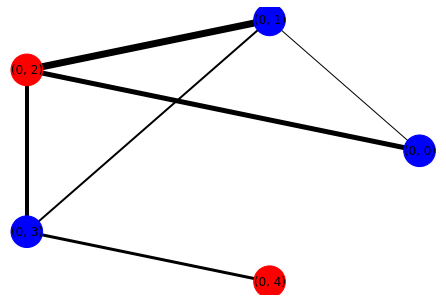

Cut size: 19.0


-----RANDOM-----


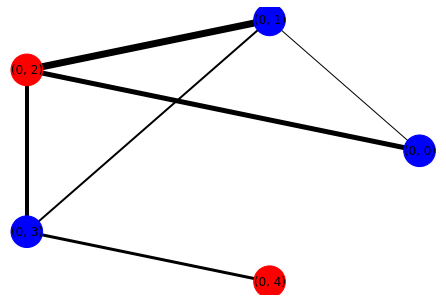

Cut size: 19.0


In [ ]:
print('-----QAOA-----')
output_cut(best_qaoa_S_partition)

print('\n\n-----RANDOM-----')
output_cut(best_random_S_partition)